In [1]:
import os
import time
from minbpe import BasicTokenizer
import torch


# open some text and train a vocab of 512 tokens
text = open("goods_zh_cleaned.txt", "r", encoding="utf-8").read()

# create a directory for models, so we don't pollute the current directory
os.makedirs("models", exist_ok=True)

t0 = time.time()
for TokenizerClass, name in zip([BasicTokenizer], ["basic"]):

    # construct the Tokenizer object and kick off verbose training
    tokenizer = TokenizerClass()
    tokenizer.train(text, 1024, verbose=True)
    # writes two files in the models directory: name.model, and name.vocab
    prefix = os.path.join("models_CN", name)
    tokenizer.save(prefix)
t1 = time.time()

print(f"Training took {t1 - t0:.2f} seconds")

merge 1/768: (239, 188) -> 256 (b'\xef\xbc') had 373488 occurrences
merge 2/768: (256, 140) -> 257 (b'\xef\xbc\x8c') had 313305 occurrences
merge 3/768: (228, 184) -> 258 (b'\xe4\xb8') had 300507 occurrences
merge 4/768: (230, 156) -> 259 (b'\xe6\x9c') had 161280 occurrences
merge 5/768: (228, 186) -> 260 (b'\xe4\xba') had 144290 occurrences
merge 6/768: (231, 154) -> 261 (b'\xe7\x9a') had 120681 occurrences
merge 7/768: (261, 132) -> 262 (b'\xe7\x9a\x84') had 119770 occurrences
merge 8/768: (258, 141) -> 263 (b'\xe4\xb8\x8d') had 105487 occurrences
merge 9/768: (228, 185) -> 264 (b'\xe4\xb9') had 103005 occurrences
merge 10/768: (232, 191) -> 265 (b'\xe8\xbf') had 96588 occurrences
merge 11/768: (260, 134) -> 266 (b'\xe4\xba\x86') had 90093 occurrences
merge 12/768: (230, 152) -> 267 (b'\xe6\x98') had 86105 occurrences
merge 13/768: (257, 229) -> 268 (b'\xef\xbc\x8c\xe5') had 85911 occurrences
merge 14/768: (128, 130) -> 269 (b'\x80\x82') had 80438 occurrences
merge 15/768: (229, 164)

In [2]:
# load models and vocabularies
# #basic_tokenizer = BasicTokenizer()
basic_tokenizer = BasicTokenizer()

# basic_tokenizer.load("models_shakespeare/basic.model")
basic_tokenizer.load("models_CN/basic.model")

In [3]:
token_vocab_size = 1024

# tokenize the text using the basic tokenizer

data = torch.tensor(basic_tokenizer.encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [4]:
print(data.shape)

torch.Size([4445662])


In [5]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 50
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
train_losses = []
val_losses = []

In [6]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import time
import matplotlib.pyplot as plt

In [7]:

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def  estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication fo llowed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


In [8]:
vocab_size = token_vocab_size

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [9]:


model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

t0 = time.time()
for iter in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:    
        losses = estimate_loss()
        train_loss = losses['train']
        val_loss = losses['val']
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
t1 = time.time()
print(f"Training took {t1 - t0:.2f} seconds")

11.5264 M parameters
step 0: train loss 7.0152, val loss 7.0154
step 50: train loss 6.0755, val loss 6.0756
step 100: train loss 4.8175, val loss 4.8229
step 150: train loss 4.5344, val loss 4.5446
step 200: train loss 4.4158, val loss 4.4309
step 250: train loss 4.3373, val loss 4.3515
step 300: train loss 4.2608, val loss 4.2782
step 350: train loss 4.1495, val loss 4.1687
step 400: train loss 4.0254, val loss 4.0413
step 450: train loss 3.9026, val loss 3.9296
step 500: train loss 3.8099, val loss 3.8378
step 550: train loss 3.7225, val loss 3.7509
step 600: train loss 3.6603, val loss 3.6933
step 650: train loss 3.5983, val loss 3.6383
step 700: train loss 3.5531, val loss 3.5919
step 750: train loss 3.5094, val loss 3.5590
step 800: train loss 3.4733, val loss 3.5260
step 850: train loss 3.4386, val loss 3.4937
step 900: train loss 3.4090, val loss 3.4639
step 950: train loss 3.3758, val loss 3.4396
step 1000: train loss 3.3488, val loss 3.4172
step 1050: train loss 3.3298, val lo

(101,)
(101,)


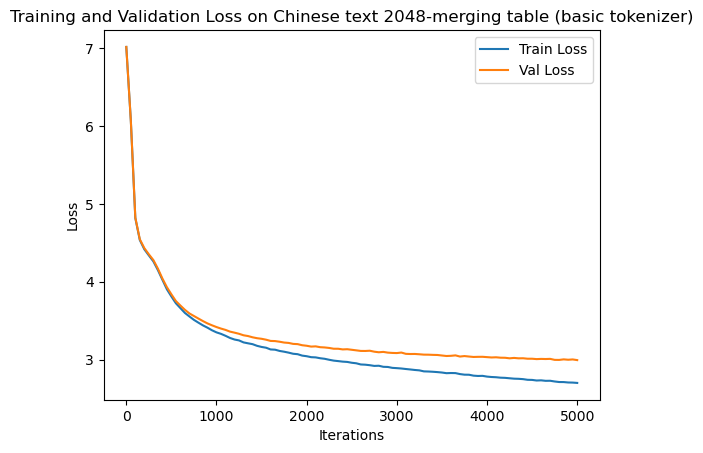

In [11]:
import numpy as np
print(np.array(train_losses).shape)
print(np.array(val_losses).shape)

plt.plot(range(0, max_iters+1, eval_interval), train_losses, label='Train Loss')
plt.plot(range(0, max_iters+1, eval_interval), val_losses, label='Val Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss on Chinese text 2048-merging table (basic tokenizer)')
plt.legend()
plt.show()


In [15]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
output = basic_tokenizer.decode(m.generate(context, max_new_tokens=1000)[0].tolist())
# open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))


In [16]:
print(output)

 据说800多持条件！就这样欺骗客户~
质量还不错，也很好，穿着很舒服。
宝贝收到了，卖家给力，态度也很好，值得购买！机箱材质还好，大家可以看好远
开机很快，主机音质不错
非常失望，电脑质量太差了，有点卡
不好用，质量太次了！差评！！！！
速度非常快，价格低的单独买就到货啦，主机又需要报时价格实惠。商品的设置。非常棒！
这是第一次在京东买东西，刚好哎，卖家还送了小米厂家配送超级慢，一点点还不让等多久，不用让我退货不送了，硬要比实体店买的*的还厉害删掉的，以后决不子令人感觉真的不清晰，差评了！服务差！
很好，这个价格能买到非常快。但是鞋子很合适，做工好。男老舒服。非常喜欢
说好的活动，意外降了同根还来不然，其中十二倒火，客服妍不虚众号。
好的，买好用
所谓卖店没有售后，从客户一直不管�不了爱你，给客服联系40000他说没人回话。换一个还是而退钱。送了个三次电话卡扣*，好吧，死，让别人保和喇叭比你塑料膜呀哈。咨询。他就找京东，京东客服就说，总之你们都不管了，奉劝各位，戴尽大家都别买了。售后问题，花钱买了个好都有过的。不管了。真的不愤怒，体验极差！正常用段时间再说。
沟通知门店，骗我给30，没发，5.2号中京东05号左右到，3.7号送到，当时到送，10号一直都没有送到，我下了昨天，额头左右也没送到货，购买前说挺快的，错 让我在客服打电话过去，说预定内存号送上门，然后到不了然后转了发过来
感觉不知道怎么样材料到假货单过了，才知道为什么给那个二手手机，冗�给好评
还可以吧就是买完就降价不理体声器好垃圾
用了一个月，付款后，不是现在做过最差，有一个人要求，明明就要了，采购中的差评！！！
时间很长认真命，还这么贵，第一用会就*。
挺好看的，就是刚妨的红色不错，差到是不用派味，很不满意，来了个二手货。而且耽评。
懒人!
听说使用过那么久壳在我一下盒子里的塞壳，连个破
手机发烫严重，抱着根本就不是了，是不是该机呀，然后再换，我自动给我一个低端还是有价？
居然不给差评差评。
手机版本激活太麻烦了，买回来二手N尔玩APP口袋玩具，
物流的太差劲了 后面不清楚 设计波触摸板还有漏光现象 还不让等待工作位置 还比较齐 第一次买笔记本电脑 京东也给暖二手的。
手机是好好的，试了试也很不错，都是正合脚布料很好哦
非常好的一件衣服，上脚布料性很好的，也很软
当时宽穿的，上身效果摸起来超级舒服，很修